In [2]:
import pandas as pd
import numpy as np
import re
import math
from pathlib import Path
from IPython.display import display

root = Path(".")

def pick_col(df, candidates):
    def norm(s): return re.sub(r'\s+', ' ', str(s).strip().lower())
    cols = [(norm(c), c) for c in df.columns]
    for pat in candidates:
        p = pat.lower()
        for lc, orig in cols:
            if p in lc:
                return orig
    return None

def choose_f1_col(df):
    cols = list(df.columns)
    cand = [c for c in cols if "f1" in c.lower()]
    prio = [c for c in cand if any(k in c.lower() for k in ["val", "valid", "test"])]
    if prio: return prio[0]
    if cand: return cand[0]
    acc = [c for c in cols if "accuracy" in c.lower()]
    acc_prio = [c for c in acc if any(k in c.lower() for k in ["val", "valid", "test"])]
    if acc_prio: return acc_prio[0]
    return acc[0] if acc else None

def to_num_series(s):
    def conv(x):
        if pd.isna(x): return np.nan
        z = str(x).strip().lower()
        z = re.sub(r'(sec\.?|s)$', '', z).strip()
        z = re.sub(r'[^\d\.\-eE]+', '', z)
        try: return float(z)
        except: return np.nan
    return s.map(conv)

def run_stats(p):
    df = pd.read_csv(p)
    f1c = choose_f1_col(df)
    rtc = pick_col(df, ["Total Time of FL Round","Total Round Time","Total FL Time","round total time"])
    agc = pick_col(df, ["Agent Time (s)","Agent Time","Agent(s) Time Overhead","Reasoning Overhead","Agent Overhead"])
    if f1c:
        if "FL Round" in df.columns:
            mx = df["FL Round"].max()
            f1s = pd.to_numeric(df.loc[df["FL Round"]==mx, f1c], errors="coerce").dropna()
            f1 = f1s.iloc[-1] if len(f1s) else np.nan
        else:
            f1s = pd.to_numeric(df[f1c], errors="coerce").dropna()
            f1 = f1s.iloc[-1] if len(f1s) else np.nan
    else:
        f1 = np.nan
    ttime = to_num_series(df[rtc]).dropna().sum() if rtc else np.nan
    if agc:
        ats = to_num_series(df[agc]).dropna()
        atime = ats.iloc[-1] if len(ats) else np.nan
    else:
        atime = np.nan
    return f1, ttime, atime

def mwu_u_from_samples(x, y):
    u = 0.0
    for xi in x:
        for yj in y:
            if xi > yj: u += 1.0
            elif xi == yj: u += 0.5
    n1, n2 = len(x), len(y)
    return u, n1*n2 - u

def mwu_exact_p_two_sided(x, y):
    x = list(map(float, x)); y = list(map(float, y))
    n1, n2 = len(x), len(y)
    if n1 == 0 or n2 == 0: return np.nan, np.nan
    U1, U2 = mwu_u_from_samples(x, y)
    U_obs = min(U1, U2)
    maxU = n1*n2
    f = [0]*(maxU+1)
    f[0] = 1
    for i in range(1, n1+1):
        g = [0]*(maxU+1)
        max_ui = i*n2
        for u in range(0, max_ui+1):
            kmax = min(u, n2)
            s = 0
            for k in range(kmax+1):
                s += f[u-k]
            g[u] = s
        f = g
    total = float(math.comb(n1+n2, n1))
    pmf_obs = f[int(U_obs)]/total
    cdf_left = sum(f[:int(U_obs)+1])/total
    p_two = 2.0*min(cdf_left, 1.0 - cdf_left + pmf_obs)
    return U_obs, min(1.0, p_two)

def holm_correction(pvals, names, alpha=0.05):
    order = np.argsort(pvals)
    m = len(pvals)
    sig = {n: False for n in names}
    prev_ok = True
    for rank, idx in enumerate(order, start=1):
        thr = alpha/(m - rank + 1)
        if pvals[idx] <= thr and prev_ok:
            sig[names[idx]] = True
            prev_ok = True
        else:
            prev_ok = False
    return sig

# ---- ORDINAMENTO PERSONALIZZATO: segue la tabella ----
def order_index(name: str) -> int:
    s = name.lower()
    s = re.sub(r"[`_()\-\s]+", " ", s)  # normalizza separatori
    def has(*tokens): return any(t in s for t in tokens)
    if has("random"): return 0
    if has("llama3.2") and has("zs", "zero shot", "zero-shot", "zero"): return 1
    if has("llama3.2") and has("fs", "few shot", "few-shot", "few"):   return 2
    if has("deepseek", "deepseek r1") and has("zs", "zero shot", "zero-shot", "zero"): return 3
    if has("deepseek", "deepseek r1") and has("fs", "few shot", "few-shot", "few"):   return 4
    if has("gpt oss", "gpt-oss", "gptoss") and has("zs", "zero shot", "zero-shot", "zero"): return 5
    if has("gpt oss", "gpt-oss", "gptoss") and has("fs", "few shot", "few-shot", "few"):   return 6
    return 100  # tutto il resto in coda, poi alfabetico

metrics = {}
for exp_dir in sorted([d for d in root.iterdir() if d.is_dir()]):
    files = []
    for f in exp_dir.glob("*.csv"):
        if re.fullmatch(r'r?\d+\.csv', f.name): files.append(f)
    files = sorted(files, key=lambda x: int(re.search(r'\d+', x.stem).group())) if files else []
    if not files: continue
    acc, tfl, aoh = [], [], []
    for f in files:
        f1, tt, at = run_stats(f)
        if not np.isnan(f1): acc.append(float(f1))
        if not np.isnan(tt): tfl.append(float(tt))
        if not np.isnan(at): aoh.append(float(at))
    if acc or tfl or aoh:
        metrics[exp_dir.name] = {"acc": acc, "time": tfl, "over": aoh}

# usa l'ordine desiderato, poi alfabetico come tie-break
configs = sorted(metrics.keys(), key=lambda k: (order_index(k), k.lower()))

baseline = next((k for k in configs if k.lower() == "random"), (configs[0] if configs else None))

def mean_std(a):
    if not a: return (np.nan, np.nan, 0)
    v = np.array(a, float)
    return (float(np.mean(v)), float(np.std(v, ddof=1)) if v.size>1 else 0.0, int(v.size))

rows = []
for c in configs:
    m = metrics[c]
    acc_m, acc_s, n_acc = mean_std(m["acc"])
    t_m, t_s, n_t = mean_std(m["time"])
    o_m, o_s, n_o = mean_std(m["over"])
    rows.append({
        "Configuration": c,
        "acc_mean": acc_m, "acc_std": acc_s,
        "time_mean": t_m, "time_std": t_s,
        "over_mean": o_m, "over_std": o_s,
        "n_runs": max(n_acc, n_t, n_o)
    })

# NON riordinare alfabeticamente: mantieni l'ordine custom
summary = pd.DataFrame(rows)

sig_acc = {}; sig_time = {}; sig_over = {}
if baseline is not None:
    names = [c for c in configs if c != baseline]
    if names:
        def p_or_nan(base, other):
            if len(base)>=1 and len(other)>=1:
                _, p = mwu_exact_p_two_sided(base, other)
                return p
            return np.nan
        p_acc = [p_or_nan(metrics[baseline]["acc"],  metrics[c]["acc"])  for c in names]
        p_time = [p_or_nan(metrics[baseline]["time"], metrics[c]["time"]) for c in names]
        p_over = [p_or_nan(metrics[baseline]["over"], metrics[c]["over"]) for c in names]
        p_acc  = np.array([1.0 if np.isnan(x) else x for x in p_acc])
        p_time = np.array([1.0 if np.isnan(x) else x for x in p_time])
        p_over = np.array([1.0 if np.isnan(x) else x for x in p_over])
        sig_acc  = holm_correction(p_acc,  np.array(names), alpha=0.05)
        sig_time = holm_correction(p_time, np.array(names), alpha=0.05)
        sig_over = holm_correction(p_over, np.array(names), alpha=0.05)

def fmt_acc(m,s,mark):
    if np.isnan(m): return ""
    t = f"{m:.2f} ± {s:.2f}"
    return t + ("*" if mark else "")

def fmt_sec(m,s,mark):
    if np.isnan(m): return ""
    t = f"{int(round(m))} ± {int(round(s))} s"
    return t + ("*" if mark else "")

disp = pd.DataFrame({
    "Configuration": summary["Configuration"],
    "Model Accuracy (mean ± std)": [
        fmt_acc(r.acc_mean, r.acc_std, bool(sig_acc.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "Total FL Time (mean ± std)": [
        fmt_sec(r.time_mean, r.time_std, bool(sig_time.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "Agent Overhead (mean ± std)": [
        fmt_sec(r.over_mean, r.over_std, bool(sig_over.get(r.Configuration, False)))
        for r in summary.itertuples()
    ],
    "n_runs": summary["n_runs"]
})

display(disp)

def to_tex_row(row):
    return f"{row['Configuration']} & {row['Model Accuracy (mean ± std)']} & {row['Total FL Time (mean ± std)']} & {row['Agent Overhead (mean ± std)']} \\\\"

latex_rows = [to_tex_row(r) for _, r in disp.iterrows()]
latex = r"""\begin{table}[h]
  \centering
      \caption{Random and LLMs Performance Benchmark. Statistical validity via 10 repeats and Mann--Whitney U at 95\%.\\
      ZS = Zero-Shot; FS = Few-Shot. Asterisk (*) indicates significant difference vs baseline.}
  \label{tab:LLMsBenchmark}
  \resizebox{\linewidth}{!}{%
  \begin{tabular}{@{}l@{}ccc@{}}
    \toprule    
    \textbf{Configuration} & \textsc{\textbf{Model Accuracy}} & \textsc{\textbf{Total FL Time}} & \textbf{Agent Overhead} \\
    \midrule
""" + "\n".join(latex_rows) + r"""
    \bottomrule
  \end{tabular}
  }
\end{table}
"""

Path("LLM_summary_stats.csv").write_text(disp.to_csv(index=False), encoding="utf-8")

,Configuration,Model Accuracy (mean ± std),Total FL Time (mean ± std),Agent Overhead (mean ± std),n_runs
0,random,0.78 ± 0.01,2222 ± 66 s,0 ± 0 s,10
1,zero-shot deepseek,0.84 ± 0.04*,1790 ± 289 s*,20 ± 5 s*,3
2,few-shot deepseek,0.82 ± 0.00,1814 ± 0 s,18 ± 0 s,1
3,few-shot gpt,0.83 ± 0.00,1842 ± 0 s,180 ± 0 s,1
4,few-shot llama,0.83 ± 0.00,1463 ± 0 s,5 ± 0 s,1
5,zero-shot gpt,0.81 ± 0.00,1944 ± 0 s,180 ± 0 s,1
6,zero-shot llama,0.82 ± 0.02,1422 ± 66 s*,7 ± 0 s*,10


454

NameError: name 'BAR_TICK_OFFSET' is not defined

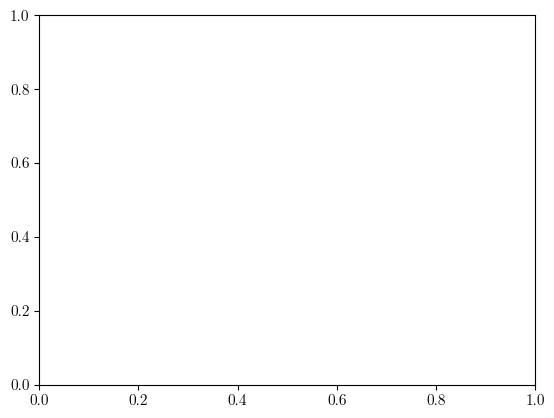

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.patches as mpatches
from matplotlib.patches import Patch

COLOR_ON   = "#66C28C"   
COLOR_OFF  = "#E06B6B"   
EDGE_COLOR = "#30363d"
EDGE_LW    = 0.5
ALPHA_BAR  = 0.95

# Hatch tenue per i rossi
plt.rcParams['hatch.color'] = '#777777'
plt.rcParams['hatch.linewidth'] = 0.6

LEGEND_HANDLES = [
    mpatches.Patch(facecolor=COLOR_ON,  edgecolor=EDGE_COLOR, linewidth=EDGE_LW, label="Architectural Pattern Active"),
    mpatches.Patch(facecolor=COLOR_OFF, edgecolor=EDGE_COLOR, linewidth=EDGE_LW, hatch="xx", label="Architectural Pattern Not Active"),
]

FORCE_ROUNDS = 10
ROUNDS = int(FORCE_ROUNDS)

approaches_rows = ["Voting-Based", "Role-Based", "Debate-Based"]
patterns = ["HDH", "MC", "CS"]

X_COL_W      = 0.03
X_GAP        = 0.00    
GROUP_GAP_X  = 0.05     
ROW_GAP      = -0.13
rect_h_v     = 0.6 - ROW_GAP   

fig2, ax2 = plt.subplots()
ytick_pos = np.arange(0.5 + BAR_TICK_OFFSET, ROUNDS + 0.5 + BAR_TICK_OFFSET, 1.0)
ax2.set_yticks(ytick_pos)
ax2.set_yticklabels([str(i) for i in range(1, ROUNDS + 1)])
ax2.set_ylabel("Federated Learning Round")

x_lefts = {}
for g_idx, appr in enumerate(approaches_rows):
    x_base = g_idx * (3 * (X_COL_W + X_GAP) + GROUP_GAP_X)
    for i, pat in enumerate(patterns):
        x_lefts[(appr, pat)] = x_base + i * (X_COL_W + X_GAP)

# limiti X
all_lefts  = [x_lefts[(a, p)] for a in approaches_rows for p in patterns]
x_min = min(all_lefts) - 0.02
x_max = max(all_lefts) + X_COL_W + 0.02
ax2.set_xlim(x_min, x_max)

# limiti Y
y_first_bottom = ytick_pos[0]  - rect_h_v/2.0
y_last_top     = ytick_pos[-1] + rect_h_v/2.0
ax2.set_ylim(y_first_bottom - 0.02, y_last_top + 0.04)

# barre
for g_idx, appr in enumerate(approaches_rows):
    for i, pat in enumerate(patterns):
        x_left = x_lefts[(appr, pat)]
        for r in range(ROUNDS):
            center_y = ytick_pos[r]
            is_on    = bool(states[appr][pat][r])
            if is_on:
                ax2.barh(y=center_y, width=X_COL_W, left=x_left, height=rect_h_v,
                         color=COLOR_ON, edgecolor=EDGE_COLOR, linewidth=EDGE_LW,
                         alpha=ALPHA_BAR, align="center", zorder=3)
            else:
                ax2.barh(y=center_y, width=X_COL_W, left=x_left, height=rect_h_v,
                         color=COLOR_OFF, edgecolor=EDGE_COLOR, linewidth=EDGE_LW,
                         hatch='xx', alpha=ALPHA_BAR, align="center", zorder=3)

trans = mtransforms.blended_transform_factory(ax2.transData, ax2.transAxes)
PAT_Y_FRAC  = -0.03
APPR_Y_FRAC = -0.10

for g_idx, appr in enumerate(approaches_rows):
    for i, pat in enumerate(patterns):
        x_center = x_lefts[(appr, pat)] + X_COL_W/2.0
        ax2.text(x_center, PAT_Y_FRAC, pat, transform=trans,
                 ha='center', va='top', fontsize=PAT_FS, clip_on=False)

for g_idx, appr in enumerate(approaches_rows):
    x_base   = g_idx * (3 * (X_COL_W + X_GAP) + GROUP_GAP_X)
    x_groupc = x_base + (X_COL_W + X_GAP) * 1 + X_COL_W/2.0
    ax2.text(x_groupc, APPR_Y_FRAC, appr, transform=trans,
             ha='center', va='top', fontsize=APPR_FS, clip_on=False)

ax2.grid(False)
ax2.set_xticks([]); ax2.set_xticklabels([]); ax2.tick_params(axis='x', length=0)
ax2.legend(handles=LEGEND_HANDLES, bbox_to_anchor=(-0.07, 1.15), loc='upper left', ncol=2, frameon=True)
plt.subplots_adjust(bottom=0.25)
plt.savefig("patternActivationVert.pdf", bbox_inches="tight", dpi=600)
plt.show()

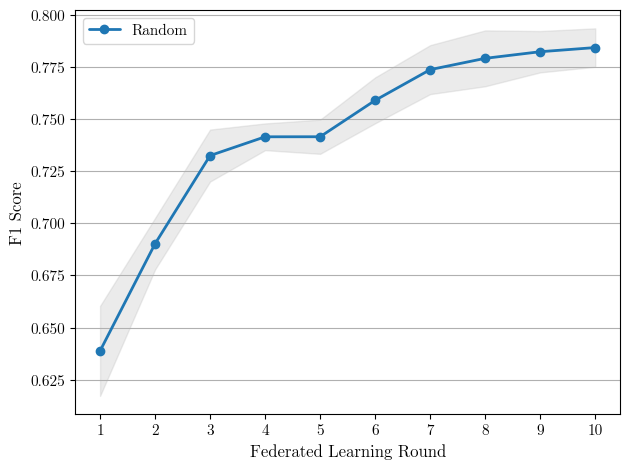

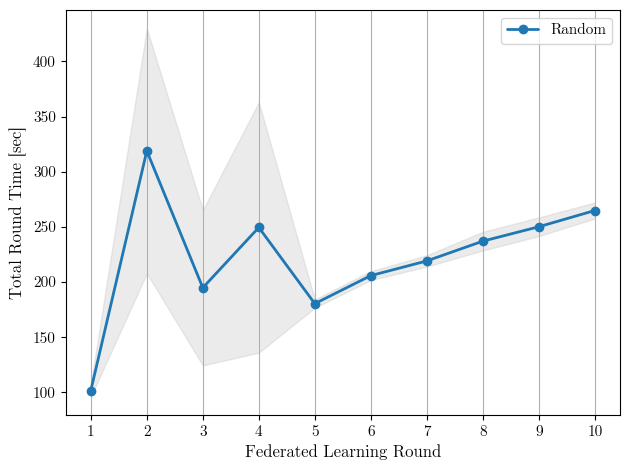

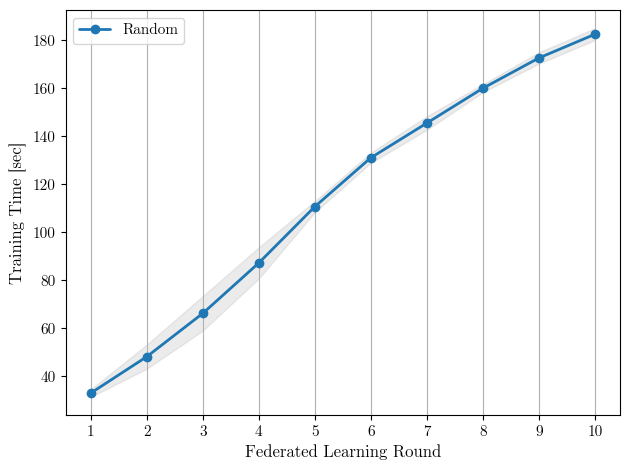

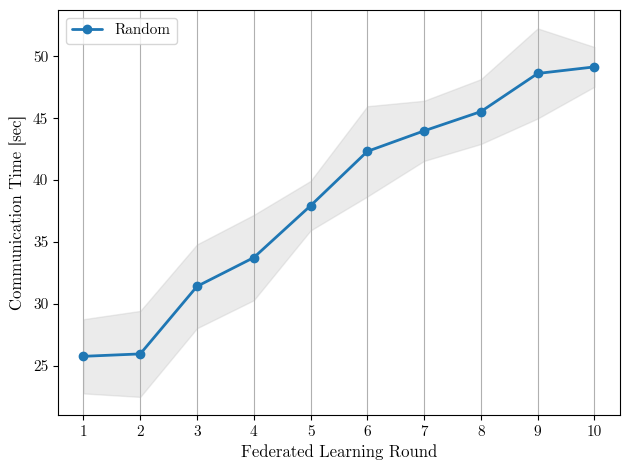

In [4]:
import os, glob
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

SAVEFIG=False
BASE_DIR='.'
plt.rcParams['font.family']='CMU Serif'
plt.rcParams['axes.labelsize']=12
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize']=11

folders={"random":"Random","voting-based":"Voting-Based","role-based":"Role-Based","debate-based":"Debate-Based"}
order=list(folders.values())
mark={"Random":"o","Voting-Based":"s","Role-Based":"^","Debate-Based":"D"}
ls={"Random":"-","Voting-Based":"--","Role-Based":":","Debate-Based":"-."}

files=sum([glob.glob(os.path.join(BASE_DIR,k,"*.csv")) for k in folders],[])
def read_norm(p):
    df=pd.read_csv(p)
    df=df.rename(columns={
        "FL Round":"round",
        "Client ID":"client",
        "Val F1":"F1",
        "Total Round Time":"total_time",
        "Total Time of FL Round":"total_time",
        "Total Time":"total_time",
        "Training Time":"training_time",
        "Communication Time":"communication_time",
    })
    for c in ["round","F1","total_time","training_time","communication_time"]:
        df[c]=pd.to_numeric(df[c].astype(str).str.replace('\u202f','').str.replace(' ','').str.replace(',','.',regex=False),errors="coerce")
    df["round"]=df["round"].astype(int)
    df["approach"]=folders[os.path.basename(os.path.dirname(p))]
    df["run"]=os.path.splitext(os.path.basename(p))[0]
    return df[["approach","run","round","F1","total_time","training_time","communication_time"]]

DF=pd.concat([read_norm(p) for p in files],ignore_index=True)
G=DF.groupby(["approach","run","round"],as_index=False).mean(numeric_only=True)
A=G.groupby(["approach","round"]).agg({"F1":["mean","std","count"],"total_time":["mean","std","count"],"training_time":["mean","std","count"],"communication_time":["mean","std","count"]})
present=list(pd.Index(order).intersection(A.index.get_level_values("approach").unique()))
xt=sorted(A.index.get_level_values("round").unique())

def kfmt(x,pos):
    if x==0: return "0"
    if abs(x)>=1000:
        v=x/1000.0
        return f"{v:.1f}k" if (v%1) else f"{int(v)}k"
    return f"{int(x)}"

def draw(metric,ylabel,grid_axis,yfmt=False,fname=None):
    fig,ax=plt.subplots()
    for a in present:
        stat=A.loc[a,metric]
        m=stat["mean"]
        s=stat["std"].fillna(0)
        n=stat["count"].clip(lower=1)
        ci=1.96*s/np.sqrt(n)
        lo=m-ci; hi=m+ci
        if metric=="F1":
            lo=lo.clip(0,1); hi=hi.clip(0,1)
        ax.plot(m.index,m.values,label=a,marker=mark[a],linewidth=2,linestyle=ls[a],solid_capstyle="round")
        ax.fill_between(m.index,lo.values,hi.values,alpha=0.25,color="#b3b3b3")
    ax.set_xlabel("Federated Learning Round"); ax.set_ylabel(ylabel)
    ax.set_xticks(xt)
    ax.grid(True,axis=grid_axis); ax.set_axisbelow(True)
    if yfmt: ax.yaxis.set_major_formatter(FuncFormatter(kfmt))
    ax.legend(); plt.tight_layout()
    _=SAVEFIG and plt.savefig(fname or f"{metric}.pdf",bbox_inches="tight")
    plt.show()

draw("F1","F1 Score","y",False,"Coordination_F1.pdf")
draw("total_time","Total Round Time [sec]","x",True,"Coordination_TotalTime.pdf")
draw("training_time","Training Time [sec]","x",True,"Coordination_TrainingTime.pdf")
draw("communication_time","Communication Time [sec]","x",True,"Coordination_CommTime.pdf")